In [7]:
### Library Imports
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from plotIndicators import plot_function
from getTickers import import_stock_data

In [8]:
### Load in Stock Data
tickers = 'GOOG'
start_date = '2018-01-01'
stock_data = import_stock_data(tickers, start_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Date,Close,High,Low
0,2018-01-02,53.250000,53.347000,52.261501
1,2018-01-03,54.124001,54.314499,53.160500
2,2018-01-04,54.320000,54.678501,54.200100
3,2018-01-05,55.111500,55.212502,54.599998
4,2018-01-08,55.347000,55.563499,55.081001
...,...,...,...,...
1584,2024-04-19,155.720001,157.990005,153.910004
1585,2024-04-22,157.949997,159.184998,155.660004
1586,2024-04-23,159.919998,160.479996,157.964996
1587,2024-04-24,161.100006,161.389999,158.820007


In [9]:
### Calculate ADX
def get_ADX(data, window):
    # Calculate True Range (TR)
    tr1 = pd.DataFrame(data['High'] - data['Low'])
    tr2 = pd.DataFrame(abs(data['High'] - data['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(data['Low'] - data['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    data['TR'] = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)

    # Calculate the Directional Movement (DM +/-) = Current High/Low - Previous High/Low (if both are positive, otherwise zero)
    for i in range(1, len(data)):
        # Build positive and negative DM columns
        pdm = data.iloc[i]['High'] - data.iloc[i - 1]['High']
        ndm = data.iloc[i - 1]['Low'] - data.iloc[i]['Low']
    
        data.at[i, 'PDM'] = pdm if pdm > 0 else 0
        data.at[i, 'NDM'] = abs(ndm) if ndm > 0 else 0

    # Smooth TR, PDM, and NDM using 14-period EMA
    data['TR_Smooth'] = data['TR'].ewm(span = window, adjust = False).mean()
    data['PDM_Smooth'] = data['PDM'].ewm(span = window, adjust = False).mean()
    data['NDM_Smooth'] = data['NDM'].ewm(span = window, adjust = False).mean()

    # Calculate the Directional Indicators (DI+ and DI-) = (PDM / Smoothed TR) * 100 and = (NDM / Smoothed TR) * 100
    data['DI+'] = (data['PDM_Smooth'] / data['TR_Smooth']) * 100
    data['DI-'] = (data['NDM_Smooth'] / data['TR_Smooth']) * 100

    # Calculate the Directional Index (DX) = (abs(DI+ - DI-) / (DI+ + DI-)) * 100
    data['DX'] = (abs(data['DI+'] - data['DI-']) / (data['DI+'] + data['DI-'])) * 100

    # Calculate Average Directional Index (ADX) = 14-period EMA of DX
    data['ADX'] = data['DX'].ewm(span = window, adjust = False).mean()

    return data

# Function Call
single_ticker = get_ADX(stock_data, window = 14)
single_ticker.tail()

,Date,Close,High,Low,TR,PDM,NDM,TR_Smooth,PDM_Smooth,NDM_Smooth,DI+,DI-,DX,ADX
1584,2024-04-19,155.720001,157.990005,153.910004,4.080002,0.000000,2.300003,3.184850,0.764088,0.744665,23.991339,23.381491,1.287336,32.820572
1585,2024-04-22,157.949997,159.184998,155.660004,3.524994,1.194992,0.000000,3.230202,0.821542,0.645377,25.433143,19.979450,12.009208,30.045724
1586,2024-04-23,159.919998,160.479996,157.964996,2.529999,1.294998,0.000000,3.136842,0.884669,0.559326,28.202552,17.830878,22.530745,29.043727
1587,2024-04-24,161.100006,161.389999,158.820007,2.569992,0.910004,0.000000,3.061262,0.888047,0.484750,29.009193,15.834959,29.377819,29.088272
1588,2024-04-25,157.949997,158.279999,152.768005,8.332001,0.000000,6.052002,3.764027,0.769641,1.227050,20.447277,32.599391,22.908346,28.264282


In [10]:
### Function for Multiple Tickers
def adx_mult_tickers(data, tickers, window = 14):
    adx_df = pd.DataFrame()  # Initialize an empty DataFrame for storing ADX values

    for t in tickers:
        # Extract data for the specific ticker using the MultiIndex
        single_ticker_data = data.loc[:, (slice(None), t)]
        single_ticker_data.columns = single_ticker_data.columns.droplevel(1)  # Drop the second level of the columns index
        single_ticker_adx = get_ADX(single_ticker_data, window=window)

        # Append the ADX values to the adx_df DataFrame
        adx_df[t] = single_ticker_adx['ADX']

    return adx_df

# Function Call for Multiple Tickers
mult_tick_list = ['AAPL', 'GOOG']
stock_data2 = import_stock_data(mult_tick_list, start_date)
#print(stock_data2.tail())
adx_df = adx_mult_tickers(stock_data2, mult_tick_list)
print(adx_df.tail())

[*********************100%%**********************]  2 of 2 completed


           AAPL       GOOG
1584  17.865466  32.820572
1585  17.782281  30.045724
1586  17.710187  29.043727
1587  15.865705  29.088272
1588  15.650624  28.264282


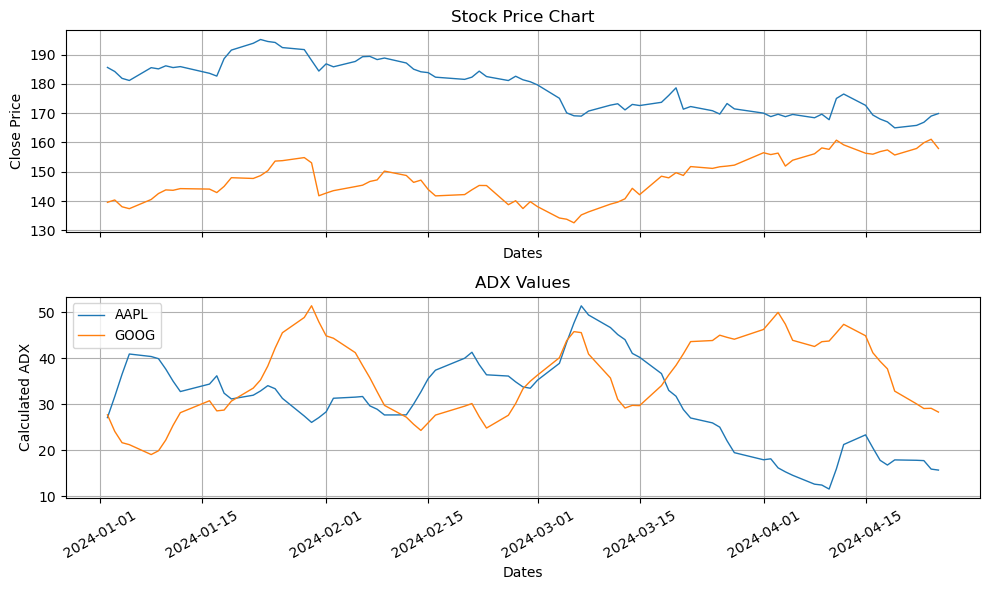

In [11]:
### Plot ADX
plot = plot_function(stock_data2, adx_df, tickers = mult_tick_list, indicator_type = 'ADX')
plot
